In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import datetime

import sys
sys.path.append('src')
import os
os.environ['GECKO_PARALLELISM'] = '16'

import matplotlib.pyplot as plt

In [4]:
from gecko.data import JPEGDataLoader

In [5]:
loader = JPEGDataLoader(camera='c3')

In [6]:
loader.base_url

'https://soho.nascom.nasa.gov/data/REPROCESSING/Completed/<<<YEAR>>>/c3/'

In [7]:
from functools import reduce
from PIL import Image

In [8]:
start_datetime = datetime.datetime(2008, 7, 8, 7, 41, 0)
end_datetime = datetime.datetime(2008, 7, 8, 15, 45, 0)

images_paths = loader.ls_images(start_datetime, end_datetime)
images = [loader.get_image(x) for x in images_paths]

In [9]:
images_paths

['20080708_0742_c3_1024.jpg',
 '20080708_0818_c3_1024.jpg',
 '20080708_0842_c3_1024.jpg',
 '20080708_0918_c3_1024.jpg',
 '20080708_0942_c3_1024.jpg',
 '20080708_1019_c3_1024.jpg',
 '20080708_1042_c3_1024.jpg',
 '20080708_1118_c3_1024.jpg',
 '20080708_1142_c3_1024.jpg',
 '20080708_1218_c3_1024.jpg',
 '20080708_1242_c3_1024.jpg',
 '20080708_1318_c3_1024.jpg',
 '20080708_1342_c3_1024.jpg',
 '20080708_1418_c3_1024.jpg',
 '20080708_1442_c3_1024.jpg',
 '20080708_1542_c3_1024.jpg']

In [10]:
from gecko.transform import Simplifier
import numpy as np

In [11]:
simplifier = Simplifier(level=150, add_pixels=2)

In [12]:
simplified_images = simplifier.transform(images)

In [13]:
simplifier = Simplifier(level=150, add_pixels=0)

In [14]:
simplified_images = simplifier.transform(images)

In [15]:
composed_img = simplifier.compose(simplified_images)

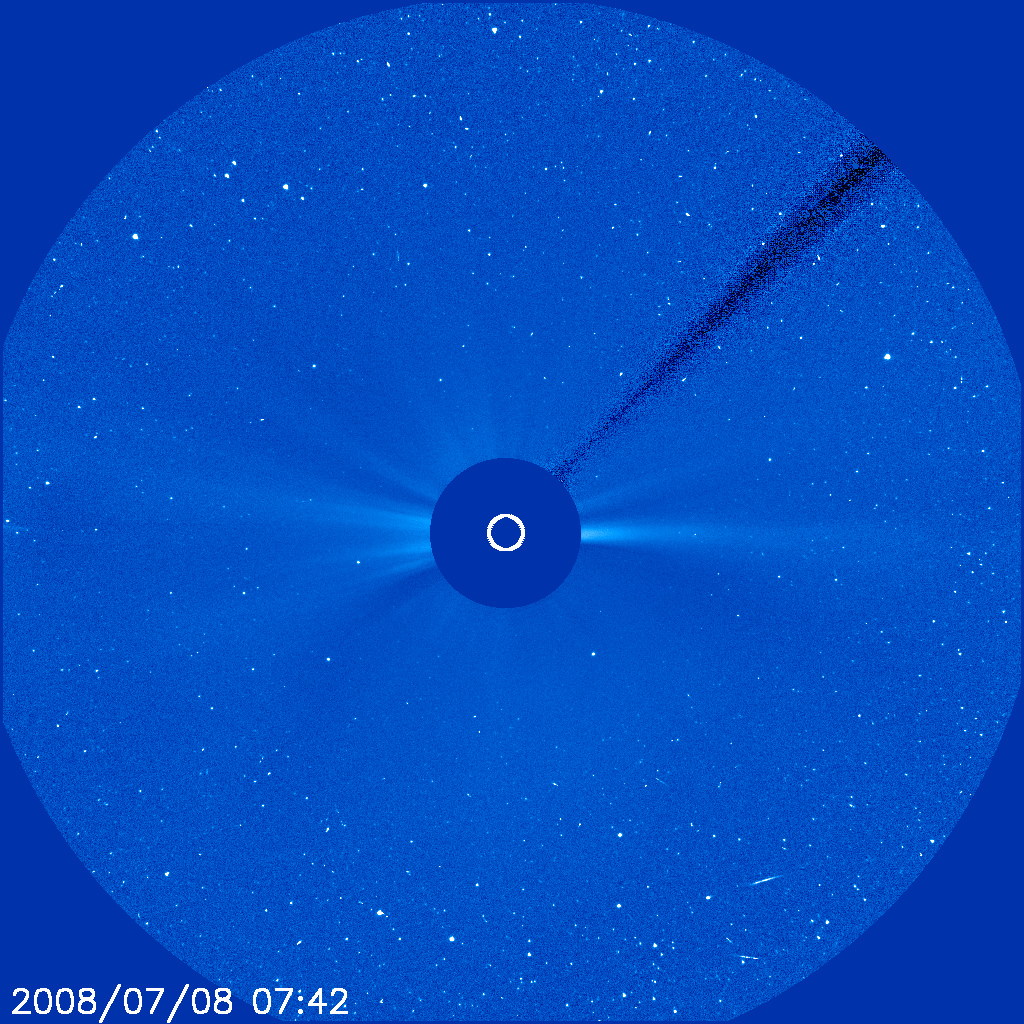

In [16]:
images[0]

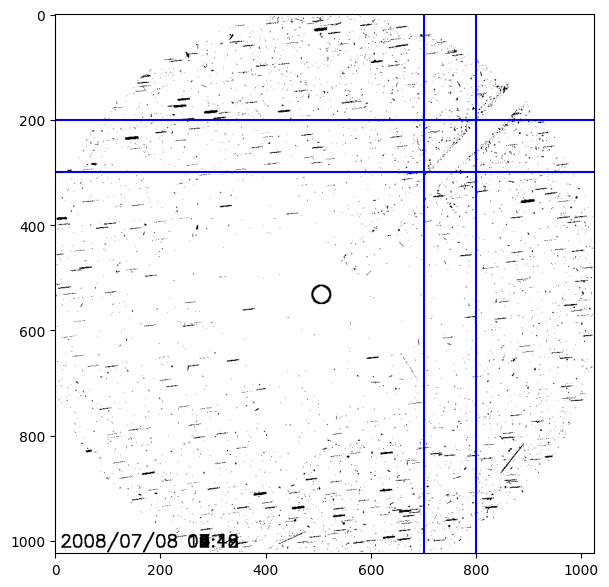

In [17]:
img = Image.fromarray(composed_img)
fig, ax = plt.subplots(figsize=(7, 7), sharex=True, sharey=True)

ax.axhline(200, color='blue')
ax.axvline(700, color='blue')
ax.axhline(300, color='blue')
ax.axvline(800, color='blue')

imgplot = plt.imshow(img, cmap='gray')

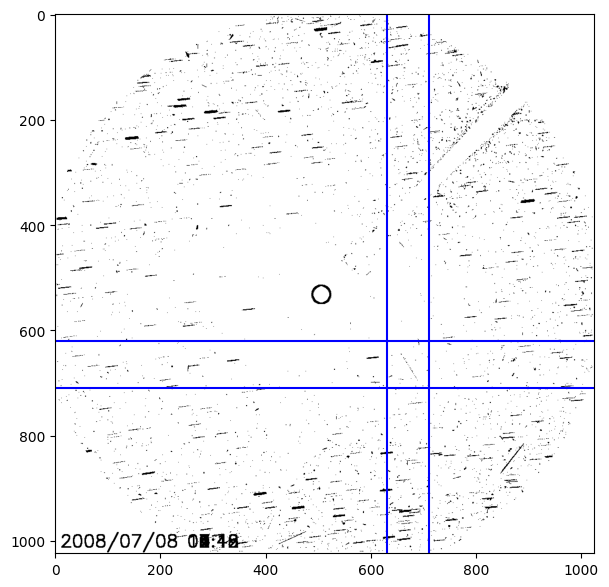

In [18]:
img = Image.fromarray(composed_img)
fig, ax = plt.subplots(figsize=(7, 7), sharex=True, sharey=True)

ax.axhline(620, color='blue')
ax.axvline(630, color='blue')
ax.axhline(710, color='blue')
ax.axvline(710, color='blue')

imgplot = plt.imshow(img, cmap='gray')

In [36]:
from itertools import combinations


class Tracer:

    def __init__(self, trajectory='linear') -> None:
        trajectory = trajectory.lower()
        if trajectory not in ('linear', 'hyperbolic'):
            raise ValueError(f'Trajectory argument must be either "linear" or "hyperbolic". Given: {trajectory}')

        self.trajectory = trajectory

    def trace(self, image):
        # search for lines, validate the speed collect coordinates and plot the trajectories 
        subregions = [
            [(620, 710), (630, 710)],
            # [(200, 250), (750, 800)],
        ]
        img_pil = image.convert('RGBA') 
        image_arr = np.asarray(img_pil)
        img_copy = image_arr.copy()
        for subregion in subregions:
            dots = []
            for i in range(subregion[0][0], subregion[0][1]):
                for j in range(subregion[1][0], subregion[1][1]):
                    if all([img_copy[i][j][0] == 0, img_copy[i][j][1] == 0, img_copy[i][j][2] == 0]):
                        dots.append((i, j))

            return dots
        
        for pair in combinations(dots, 2):
            i1, j1 = pair[0]
            i2, j2 = pair[1]
            # j = k*i + b 



In [37]:
tracer = Tracer()
dots = tracer.trace(Image.fromarray(composed_img))

In [38]:
from itertools import combinations

In [39]:
len(dots)

75

In [40]:
def are_aligned(coordinates, trajectory='linear', tol=1):
    if trajectory.lower() not in ('linear', 'hyperbolic'):
        raise ValueError
    
    if trajectory.lower() == 'linear':
        (x0, y0), (x1, y1) = coordinates[0], coordinates[1]
        for i in range(2, len(coordinates)):
           x, y = coordinates[i]
           if abs((x0 - x1) * (y1 - y) - (x1 - x) * (y0 - y1)) > tol:
              return False
        return True

In [41]:
RES = []
for row in combinations(dots, 4):
    if are_aligned(row, tol=1):
        if abs(row[0][1] - row[3][1]) > 20 and abs(row[0][0] - row[3][0]) > 20:
            RES.append(([x[0] for x in row], [x[1] for x in row]))

In [42]:
len(RES)

28

In [43]:
RES

[([645, 653, 661, 680], [657, 662, 667, 679]),
 ([645, 653, 672, 680], [657, 662, 674, 679]),
 ([645, 653, 674, 680], [657, 662, 675, 679]),
 ([645, 653, 677, 680], [657, 662, 677, 679]),
 ([645, 662, 665, 679], [657, 668, 670, 679]),
 ([645, 672, 680, 691], [657, 674, 679, 686]),
 ([646, 655, 661, 679], [657, 663, 667, 679]),
 ([646, 665, 668, 706], [657, 670, 672, 698]),
 ([646, 652, 655, 706], [658, 662, 664, 698]),
 ([646, 652, 661, 706], [658, 662, 668, 698]),
 ([646, 655, 661, 706], [658, 664, 668, 698]),
 ([646, 659, 672, 680], [658, 666, 674, 679]),
 ([646, 659, 677, 680], [658, 666, 677, 679]),
 ([646, 662, 678, 686], [658, 668, 678, 683]),
 ([652, 655, 661, 706], [662, 664, 668, 698]),
 ([652, 665, 678, 686], [662, 670, 678, 683]),
 ([652, 665, 678, 691], [662, 670, 678, 686]),
 ([652, 665, 683, 686], [662, 670, 681, 683]),
 ([652, 665, 683, 691], [662, 670, 681, 686]),
 ([652, 665, 686, 691], [662, 670, 683, 686]),
 ([653, 672, 680, 691], [662, 674, 679, 686]),
 ([653, 672, 

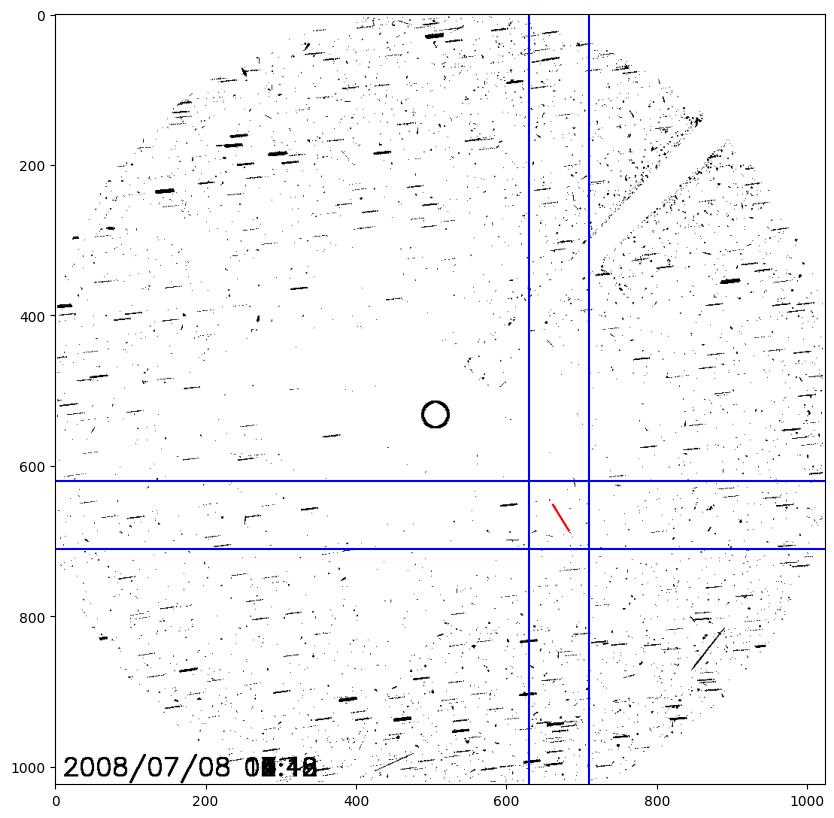

In [47]:
img = Image.fromarray(composed_img)
fig, ax = plt.subplots(figsize=(10, 10), sharex=True, sharey=True)
i = 15
ax.plot(RES[i][1], RES[i][0], color='r')

ax.axhline(620, color='blue')
ax.axvline(630, color='blue')
ax.axhline(710, color='blue')
ax.axvline(710, color='blue')

imgplot = plt.imshow(img, cmap='gray')

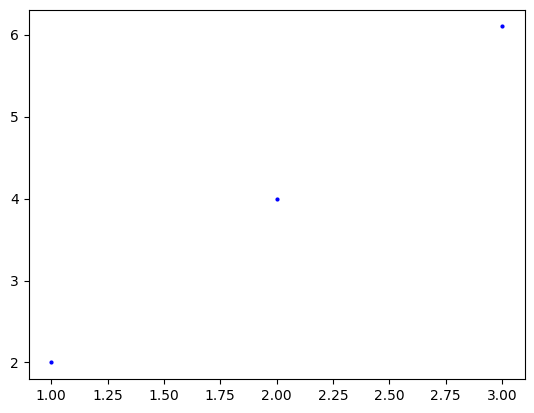

In [139]:
plt.plot(1,2, marker='o', markersize=2, color='b')
plt.plot(2,4, marker='o', markersize=2, color='b')
plt.plot(3,6.1, marker='o', markersize=2, color='b')

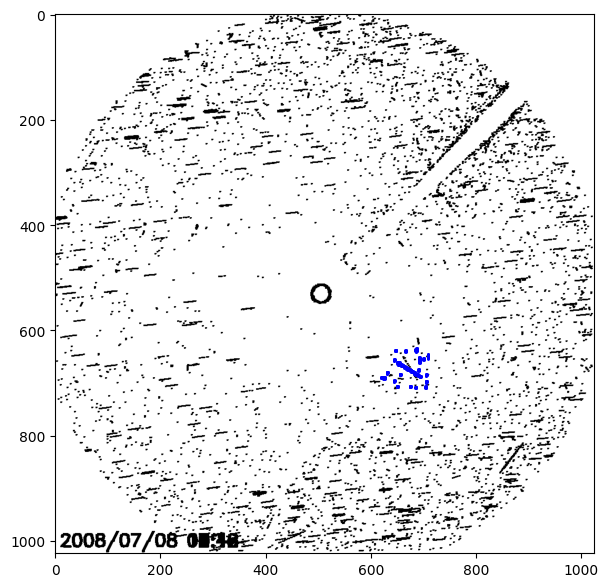

In [119]:
img = Image.fromarray(composed_img)
fig, ax = plt.subplots(figsize=(7, 7), sharex=True, sharey=True)

for dot in dots:
    ax.plot(dot[0], dot[1], marker='o', markersize=1, color='b')

imgplot = plt.imshow(img, cmap='gray')

[]